# Plots explaining robust overfitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dotenv
import pandas as pd
import mlflow
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots
import plotly.io as pio
import matplotlib.patches

import typing
import os
import shutil
import sys

In [2]:
EXPORT = False
SHOW_TITLES = not EXPORT
EXPERIMENT_NAME = 'logistic_regression_explain_ro'

In [3]:
# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, os.pardir)), 'src')
sys.path.append(MODULE_DIR)

In [4]:
%load_ext autoreload
%autoreload 2
import interpolation_robustness as ir

In [5]:
FIGURE_SIZE_LARGE = (2.6, 2.0)
FIGURE_SIZE = (1.8, 1.8)
LEGEND_FONT_SIZE = ir.plots.FONT_SIZE_SMALL_PT

ir.plots.setup_matplotlib(show_titles=SHOW_TITLES)

In [6]:
if EXPORT:
    EXPORT_DIR = os.path.join(ir.util.REPO_ROOT_DIR, 'logs', f'export_{EXPERIMENT_NAME}')
    print('Using export directory', EXPORT_DIR)
    if os.path.exists(EXPORT_DIR):
        shutil.rmtree(EXPORT_DIR)
    os.makedirs(EXPORT_DIR)

def export_fig(fig: plt.Figure, filename: str):
    # If export is disabled then do nothing
    if EXPORT:
        export_path = os.path.join(EXPORT_DIR, filename)
        fig.savefig(export_path)
        print('Exported figure at', export_path)


## Load experiment data

In [7]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
all_runs = mlflow.search_runs(
    experiment.experiment_id
)
all_runs = all_runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

# Convert some parameters to numbers and sort accordingly
all_runs['params.data_dim'] = all_runs['params.data_dim'].astype(int)
all_runs['params.train_attack_epsilon'] = all_runs['params.train_attack_epsilon'].astype(np.float)
all_runs['params.test_attack_epsilon'] = all_runs['params.test_attack_epsilon'].astype(np.float)
all_runs['params.l2_lambda'] = all_runs['params.l2_lambda'].astype(np.float)
all_runs = all_runs.sort_values(['params.l2_lambda'], ascending=False)
print('Loaded', len(all_runs), 'runs')
assert all_runs['status'].eq('FINISHED').all()
assert all_runs['params.train_consistent_attacks'].eq('True').all()

Loaded 24 runs


In [8]:
# Ignore very large lambda since nothing happens there
MIN_LAMBDA_IDX = 11
runs = all_runs.iloc[MIN_LAMBDA_IDX:]

## Plots

In [9]:
std_risk_color_idx = 0
robust_risk_color_idx = 1
data_dim, = runs['params.data_dim'].unique()
num_samples, = runs['params.data_num_train_samples'].astype(int).unique()
train_attack_epsilon, = runs['params.train_attack_epsilon'].unique()

BASELINE_LAMBDA = 0.0

In [10]:
# Load dataset params
dataset_path = os.path.join(ir.util.REPO_ROOT_DIR, 'logs', EXPERIMENT_NAME, f'dataset.npz')
dataset = np.load(dataset_path)
ground_truth = dataset['ground_truth']
x_covariance_diagonal = dataset['x_covariance_diagonal']
train_xs = dataset['train_xs']
train_ys = dataset['train_ys']
train_ys = np.where(train_ys, 1.0, -1.0)
assert np.all(x_covariance_diagonal == 1)
assert np.all(ground_truth[1:] == 0)
print('Loaded dataset')

# Load weights
data_dim, = all_runs['params.data_dim'].unique()
full_all_weights = np.zeros((len(all_runs), data_dim))
l2_lambdas = all_runs['params.l2_lambda'].unique()
for idx, run_id in enumerate(all_runs.index):
    print('Loading weights of', run_id, 'with ridge parameter', all_runs.loc[run_id]['params.l2_lambda'])
    weight_path = os.path.join(ir.util.REPO_ROOT_DIR, 'logs', EXPERIMENT_NAME, f'weights_{run_id}.npy')
    full_all_weights[idx] = np.load(weight_path)

print('Loaded weights shape:', full_all_weights.shape)

all_weights = full_all_weights[MIN_LAMBDA_IDX:]
print('Restricted weights shape:', all_weights.shape)


Loaded dataset
Loading weights of 586b48d3569f46d19e3147775a8124ac with ridge parameter 10000.0
Loading weights of ae733324794841779ace3d73c3a22db7 with ridge parameter 5000.0
Loading weights of 03f8ac9502094f469ef297b919eca327 with ridge parameter 1000.0
Loading weights of b41dfcd32822458bb5dd8c8505d0b480 with ridge parameter 500.0
Loading weights of da4edd8d98fb48ef8e6f4da828e18de7 with ridge parameter 100.0
Loading weights of 23a96c60af074e7b933d5c2aa0376f5a with ridge parameter 50.0
Loading weights of fa891f5bb81043f79a3983676b8e1c90 with ridge parameter 10.0
Loading weights of b005489871e941d5b1caafc1a5ecaa89 with ridge parameter 5.0
Loading weights of eaee7d93f8c94d658ab1304b0d927917 with ridge parameter 3.0
Loading weights of c04b88a470234ae29eea1a6fea408d7f with ridge parameter 1.0
Loading weights of 69fcb9d591864c958734c41c0110d2c3 with ridge parameter 0.8
Loading weights of c36b2e6d7eaa45ef87ab98badea17cb1 with ridge parameter 0.5
Loading weights of d6738d7847be46ef8892905bd1

In [11]:
ground_truth = ground_truth / np.linalg.norm(ground_truth)

weight_norms_l1 = np.linalg.norm(all_weights, ord=1, axis=1)
weight_norms_l2 = np.linalg.norm(all_weights, ord=2, axis=1)

gt_weights_dot = np.dot(all_weights, ground_truth)
all_weights_projected = all_weights - ground_truth * np.expand_dims(gt_weights_dot, axis=1)
weight_norms_projected_l1 = np.linalg.norm(all_weights_projected, ord=1, axis=1)

hoyer_measure = (np.sqrt(data_dim) - weight_norms_l1 / weight_norms_l2) / (np.sqrt(data_dim) - 1)
inverse_hoyer_measure = 1.0 - hoyer_measure
projected_l1_normal_l2_norm_ratio = weight_norms_projected_l1 / weight_norms_l2
l1_l2_norm_ratio = weight_norms_l1 / weight_norms_l2

loss_inputs_weights = np.expand_dims(train_ys.T, axis=0) * (all_weights @ train_xs.T)
mean_normalized_margin_weights = (np.mean(loss_inputs_weights, axis=1) - train_attack_epsilon * weight_norms_projected_l1) / weight_norms_l2
normalized_margin_weights = (np.min(loss_inputs_weights, axis=1) - train_attack_epsilon * weight_norms_projected_l1) / weight_norms_l2
std_margin = np.min(loss_inputs_weights, axis=1)
normalized_l1_norm = l1_l2_norm_ratio

loss_inputs_ground_truth = train_ys * np.dot(train_xs, ground_truth)
gt_norm_l1 = 0.0  # ground truth projected orthogonal to ground truth is 0
gt_norm_l2 = np.linalg.norm(ground_truth, ord=2)
mean_normalized_margin_gt = (np.mean(loss_inputs_ground_truth) - train_attack_epsilon * gt_norm_l1) / gt_norm_l2
normalized_margin_gt = (np.min(loss_inputs_ground_truth) - train_attack_epsilon * gt_norm_l1) / gt_norm_l2

interpolation_lambda_idx = np.argmax(std_margin > 0) - 0.5


### Standard and robust risk

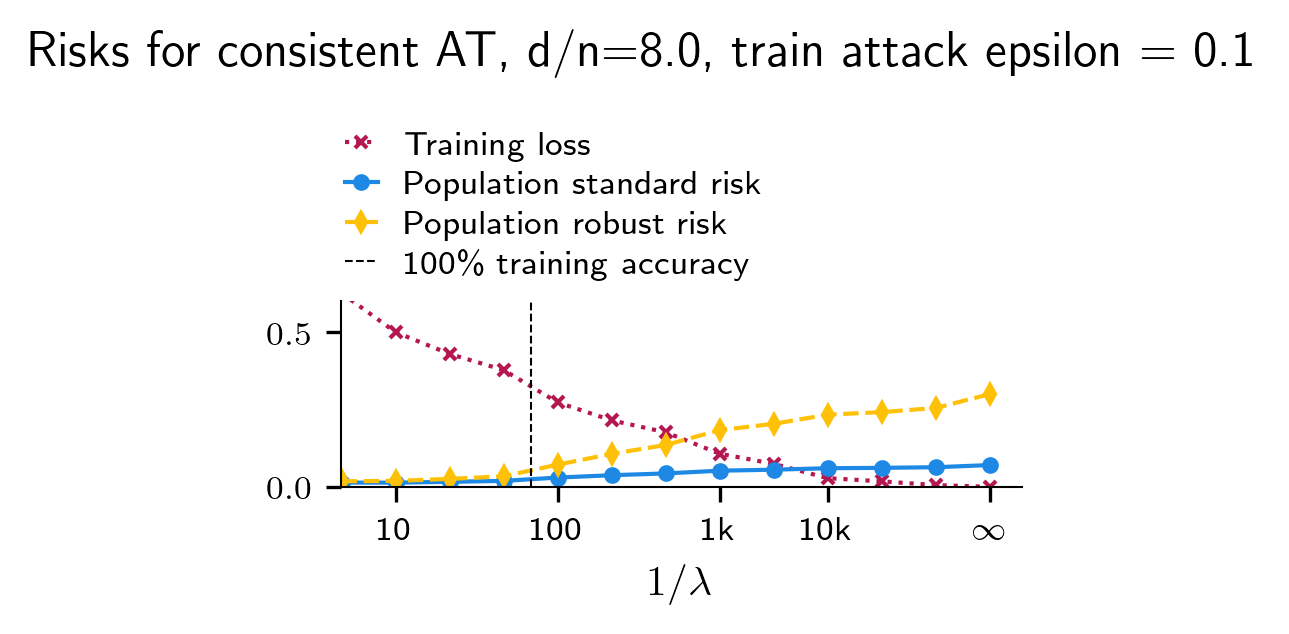

In [12]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE_LARGE)

raw_x_values = (1.0 / runs['params.l2_lambda']).round(decimals=2)
assert raw_x_values[-1] == np.inf
x_values = raw_x_values.astype(np.str)
x_ticks = ('10.0', '100.0', '1000.0', '10000.0', 'inf')
x_ticklabels = ('10', '100', '1k', '10k', r'$\infty$')

# Max margin training loss is 0, but is caclulated differently, hence need to manually adjust
training_loss = runs['metrics.training_loss'].values
training_loss[-1] = 0
training_color_idx = 2
ax.plot(
    x_values,
    training_loss,
    label='Training loss',
    c=f'C{training_color_idx}',
    ls=ir.plots.LINESTYLE_MAP[training_color_idx],
    marker=ir.plots.MARKER_MAP[training_color_idx],
    zorder=1
)

ax.plot(
    x_values,
    runs['metrics.true_std_risk'],
    label='Population standard risk',
    c=f'C{std_risk_color_idx}',
    ls=ir.plots.LINESTYLE_MAP[std_risk_color_idx],
    marker=ir.plots.MARKER_MAP[std_risk_color_idx],
    zorder=1
)
ax.plot(
    x_values,
    runs['metrics.true_robust_risk'],
    label='Population robust risk',
    c=f'C{robust_risk_color_idx}',
    ls=ir.plots.LINESTYLE_MAP[robust_risk_color_idx],
    marker=ir.plots.MARKER_MAP[robust_risk_color_idx],
    zorder=1
)

ax.axvline(interpolation_lambda_idx, ls='--', c='black', lw=0.5, zorder=2, label=r'100\% training accuracy')

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels)
ax.set_xlabel(r'$1 / \lambda$')
ax.set_ylim(bottom=-0.001, top=0.6)
ax.set_xlim(left=-0.005)

ax.legend(
    fontsize=LEGEND_FONT_SIZE,
    loc=(0.0, 1.1)
)

if SHOW_TITLES:
    fig.suptitle(f'Risks for consistent AT, d/n={data_dim / num_samples}, train attack epsilon = {train_attack_epsilon}')

export_fig(fig, f'logreg_explanation_standard_and_robust_risk.pdf')
plt.show()


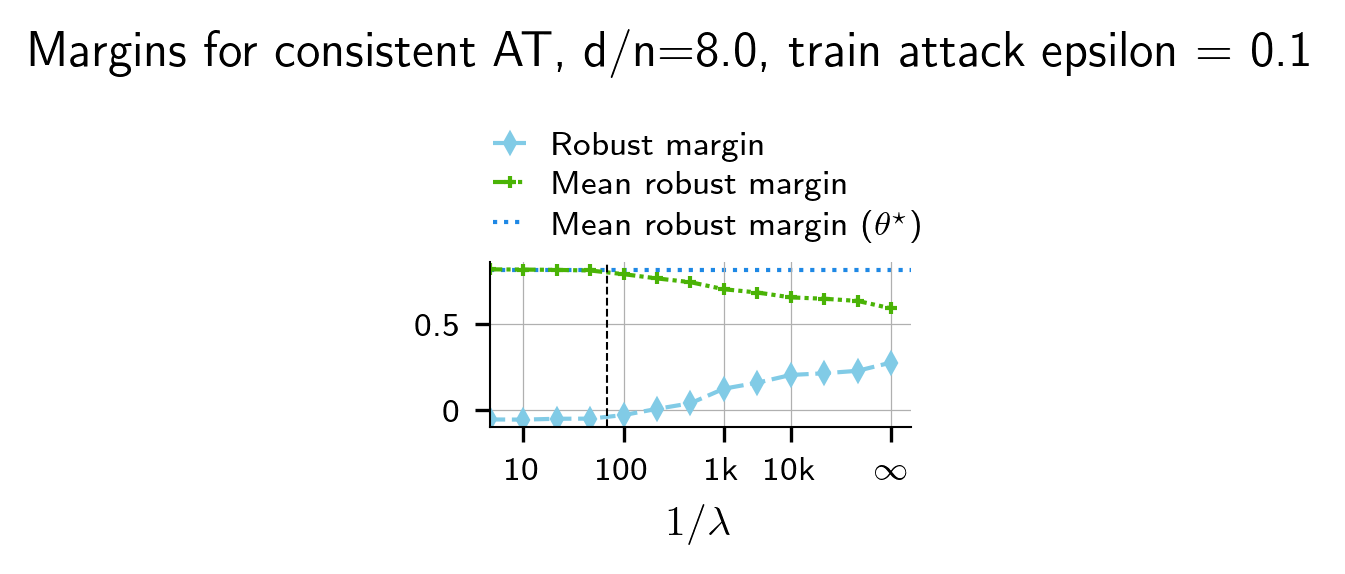

In [13]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

ax.grid(zorder=0)
ax.set_axisbelow(True)

ax.plot(
    x_values,
    normalized_margin_weights,
    label='Robust margin',
    c=f'C{3}',
    ls=ir.plots.LINESTYLE_MAP[1],
    marker=ir.plots.MARKER_MAP[1],
    zorder=1
)

ax.plot(
    x_values,
    mean_normalized_margin_weights,
    label='Mean robust margin',
    c=f'C{4}',
    ls=ir.plots.LINESTYLE_MAP[3],
    marker=ir.plots.MARKER_MAP[3],
    zorder=1
)
ax.axhline(mean_normalized_margin_gt, c='C6', zorder=0, ls=ir.plots.LINESTYLE_MAP[2], label=r'Mean robust margin ($\theta^\star$)')

ax.axvline(interpolation_lambda_idx, ls='--', c='black', lw=0.5, zorder=2)

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels)
ax.set_xlabel(r'$1 / \lambda$')
ax.set_xlim(left=-0.005)
ax.set_yticks((0, 0.5))
ax.set_yticklabels((0, 0.5))

ax.legend(
    fontsize=LEGEND_FONT_SIZE,
    loc=(0.0, 1.1)
)

if SHOW_TITLES:
    fig.suptitle(f'Margins for consistent AT, d/n={data_dim / num_samples}, train attack epsilon = {train_attack_epsilon}')

export_fig(fig, f'logreg_explanation_margins.pdf')
plt.show()


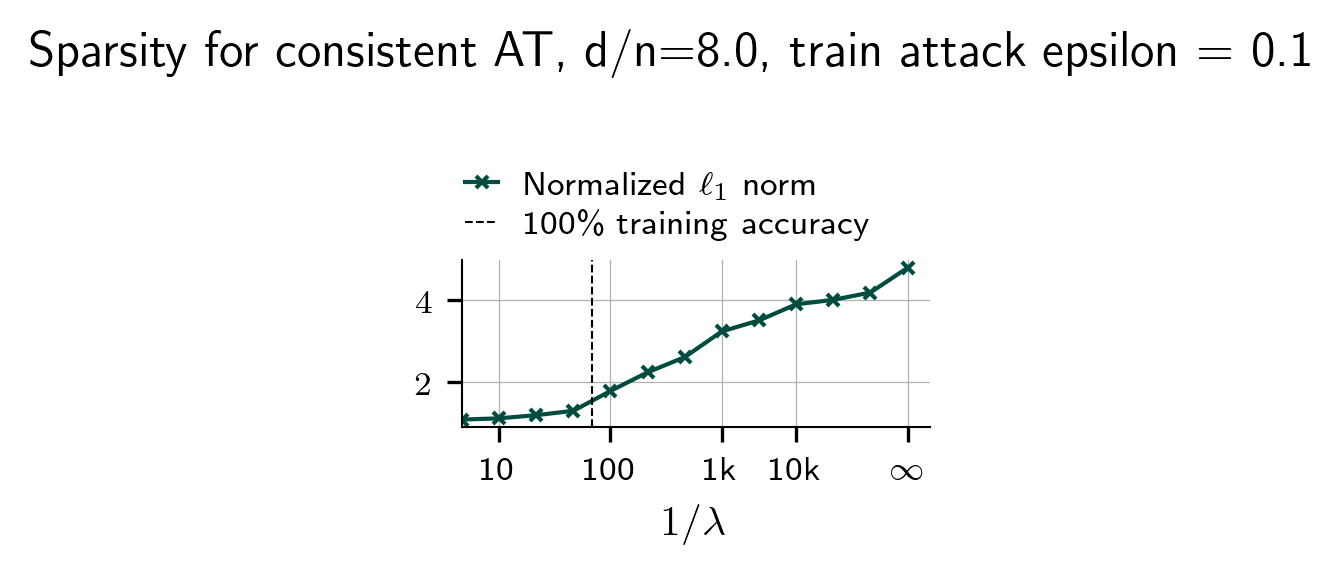

In [14]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

ax.grid(zorder=0)
ax.set_axisbelow(True)

ax.plot(
    x_values,
    normalized_l1_norm,
    label=r'Normalized $\ell_1$ norm',
    c=f'C{5}',
    ls=ir.plots.LINESTYLE_MAP[0],
    marker=ir.plots.MARKER_MAP[2],
    zorder=1
)

ax.axvline(interpolation_lambda_idx, ls='--', c='black', lw=0.5, zorder=2, label=r'100\% training accuracy')

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels)
ax.set_xlabel(r'$1 / \lambda$')
ax.set_xlim(left=-0.005)

proxy_patch = matplotlib.patches.Patch(color='none', label='')
legend_handles, legend_labels = ax.get_legend_handles_labels()

ax.legend(
    [proxy_patch] + legend_handles,
    [''] + legend_labels,
    fontsize=LEGEND_FONT_SIZE,
    loc=(0.0, 1.1)
)

if SHOW_TITLES:
    fig.suptitle(f'Sparsity for consistent AT, d/n={data_dim / num_samples}, train attack epsilon = {train_attack_epsilon}')

export_fig(fig, f'logreg_explanation_sparsity.pdf')
plt.show()


In [15]:
margin_decay_lambdas = (5, 0.0)

margin_decay = dict()
for current_lambda in margin_decay_lambdas:
    (current_lambda_idx,), = np.where(all_runs['params.l2_lambda'].unique() == current_lambda)
    current_weights = full_all_weights[current_lambda_idx]
    current_weights_projected = current_weights - ground_truth * np.dot(current_weights, ground_truth)
    current_normalized_margins = (
        train_ys * np.dot(train_xs, current_weights) - train_attack_epsilon * np.linalg.norm(current_weights_projected, ord=1)
    ) / np.linalg.norm(current_weights, ord=2)
    current_normalized_margins = np.flip(np.sort(current_normalized_margins))
    margin_decay[current_lambda] = current_normalized_margins


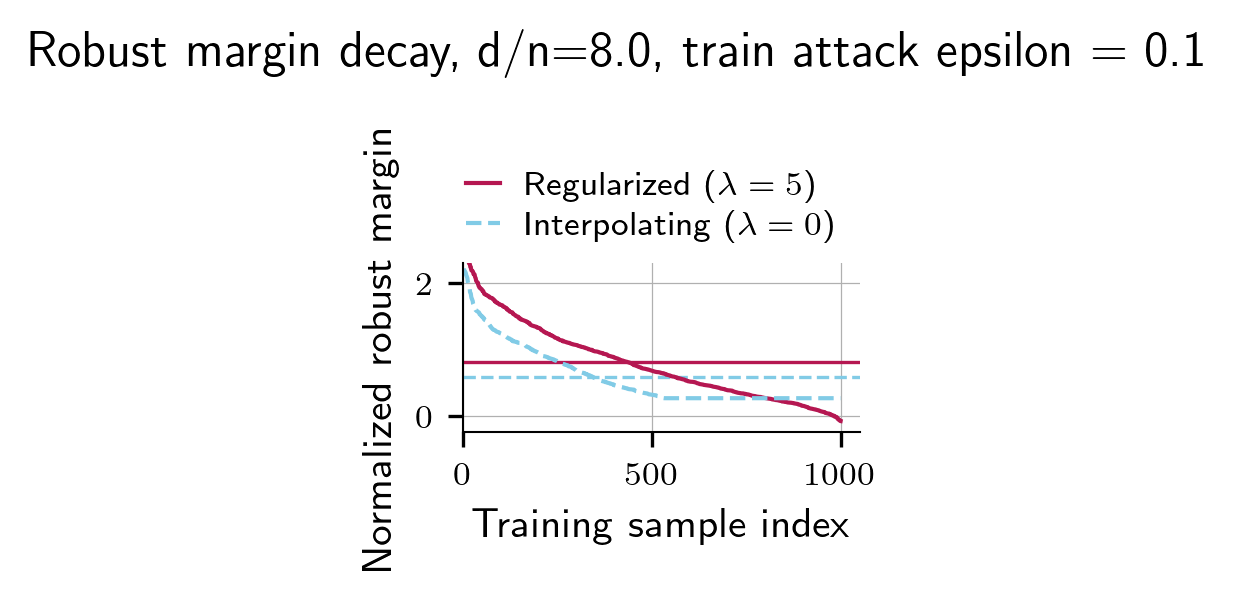

In [16]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

ax.grid(zorder=0)
ax.set_axisbelow(True)

x_values = np.arange(num_samples)

for idx, current_lambda in enumerate(margin_decay_lambdas):
    current_decay = margin_decay[current_lambda]
    label = rf'Regularized' if current_lambda > 0 else 'Interpolating'
    ax.plot(
        x_values,
        current_decay,
        label=rf'{label} ($\lambda = {current_lambda:.0f}$)',
        c=f'C{2 + idx}',
        ls=ir.plots.LINESTYLE_MAP[idx],
        zorder=2
    )
    
    ax.axhline(
        np.mean(current_decay),
        c=f'C{2 + idx}',
        ls=ir.plots.LINESTYLE_MAP[idx],
        linewidth=0.8,
        zorder=1
    )
    
ax.set_xlabel(r'Training sample index')
ax.set_xlim(left=0)
ax.set_ylabel('Normalized robust margin')
ax.set_ylim(top=2.3)

proxy_patch = matplotlib.patches.Patch(color='none', label='')
legend_handles, legend_labels = ax.get_legend_handles_labels()

ax.legend(
    [proxy_patch] + legend_handles,
    [''] + legend_labels,
    fontsize=LEGEND_FONT_SIZE,
    loc=(0.0, 1.1)
)

if SHOW_TITLES:
    fig.suptitle(f'Robust margin decay, d/n={data_dim / num_samples}, train attack epsilon = {train_attack_epsilon}')

export_fig(fig, f'logreg_explanation_robust_margin_decay.pdf')
plt.show()
